In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

In [2]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache(r'C:\Users\User\Desktop\789\f1\ver_ham_new') 

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

In [3]:
# Load the session data
race = ff1.get_session(2021, 'Abu Dhabi', 'R')

In [4]:
# Get the laps
laps = race.load_laps(with_telemetry=True)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
session     WARNING 	Request for URL https://ergast.com/api/f1/2021/22/results.json failed; using cached response
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, 

In [5]:
# Get laps of the drivers (VER and HAM)
laps_ham = laps.pick_driver('HAM')
laps_ver = laps.pick_driver('VER')

In [19]:
# Filling in the gaps of Verstappen's laps
verst_lap_1 = pd.Series(['0 days 00:01:32.800000', '0 days 00:02:30.435000'], index = [0, 54])
verst_lap_1_t = pd.to_timedelta(verst_lap_1)
laps_ver['LapTime'].fillna(value = verst_lap_1_t, inplace = True)

In [10]:
# Set the indexes in Hamilton's frame
laps_ham.reset_index(drop = True, inplace = True)

In [20]:
# Filling in the gaps of Hamilton's laps
ham_lap_1 = pd.Series(['0 days 00:01:31.686000', '0 days 00:02:32.083000'], index = [0, 54])
ham_lap_1_t = pd.to_timedelta(ham_lap_1)
laps_ham['LapTime'].fillna(value = ham_lap_1_t, inplace = True)

In [12]:
# Set the race lap
laps_ham['RaceLapNumber'] = laps_ham['LapNumber'] - 1
laps_ver['RaceLapNumber'] = laps_ver['LapNumber'] - 1

In [15]:
# create data frames
full_distance_ver_ham = pd.DataFrame()
summarized_distance_ver_ham = pd.DataFrame()

In [16]:
for lap in laps_ver.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    
    # Only run this loop when driver ahead is HAM, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "44"]
    
    if len(telemetry) != 0:
        # Full distance
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1

        #full_distance_ver_ham = full_distance_ver_ham.append(lap_telemetry)
        lap_telemetrydf = pd.DataFrame.from_records([lap_telemetry])
        full_distance_ver_ham = pd.concat([full_distance_ver_ham, lap_telemetrydf])

        # Average distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        
        
        row = {'Lap': lap[0] + 1, 'Mean': distance_mean}
        rowdf = pd.DataFrame.from_records([row])
        summarized_distance_ver_ham = pd.concat([summarized_distance_ver_ham, rowdf], ignore_index = True)

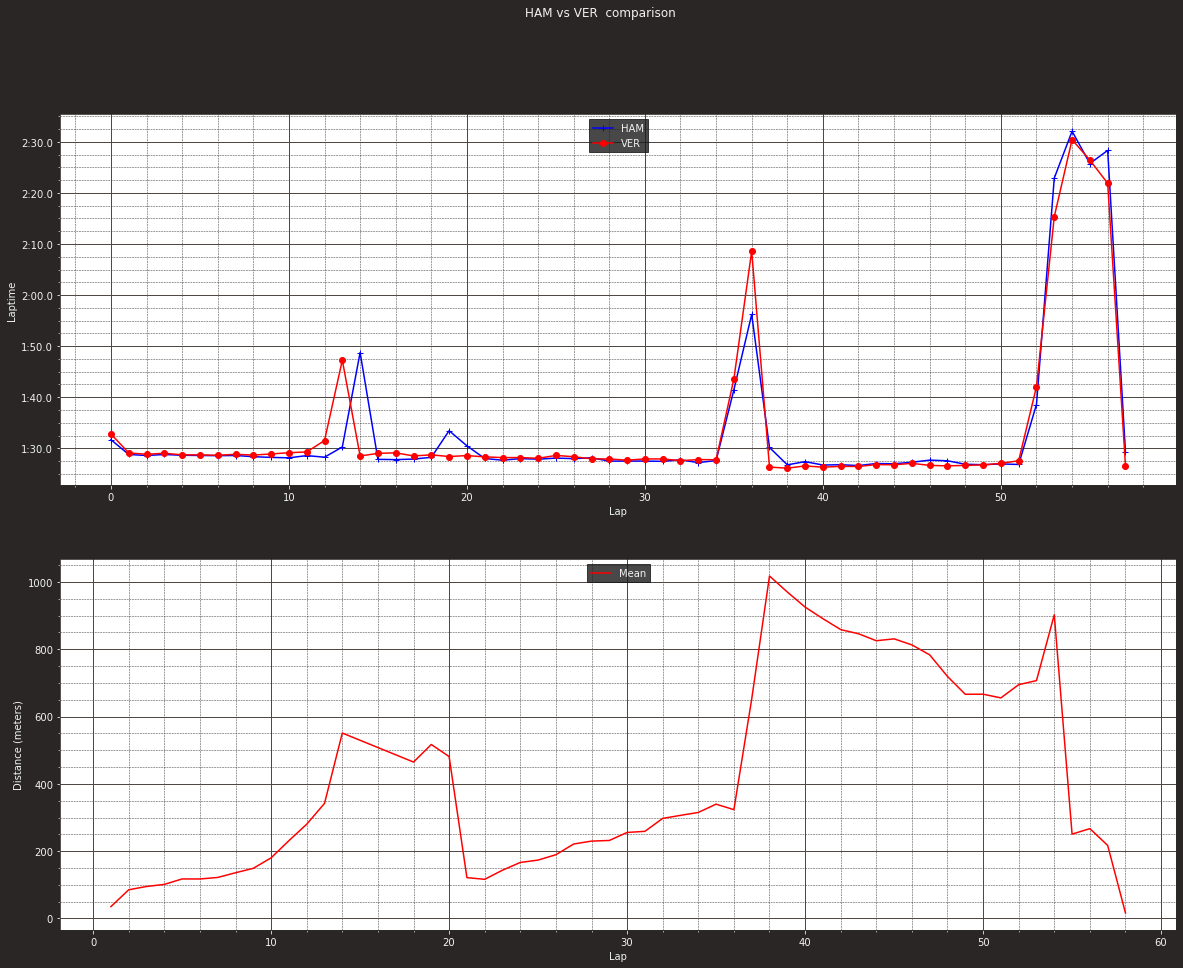

In [33]:
#plotting the first set
plt.rcParams['figure.figsize'] = [20, 15]

fig, ax = plt.subplots(2)
fig.suptitle("HAM vs VER  comparison")

ax[0].set_facecolor("white")
ax[1].set_facecolor("white")

ax[0].plot(laps_ham['RaceLapNumber'], laps_ham['LapTime'], label='HAM', marker = '+', c = 'blue')
ax[0].plot(laps_ver['RaceLapNumber'], laps_ver['LapTime'], label='VER', marker = 'o', c = 'red')
ax[0].set(ylabel='Laptime', xlabel='Lap')
ax[0].legend(loc="upper center")

ax[1].plot(summarized_distance_ver_ham['Lap'], summarized_distance_ver_ham['Mean'], label='Mean', color='red')
ax[1].set(ylabel='Distance (meters)', xlabel='Lap')
ax[1].legend(loc="upper center")


plt.show()

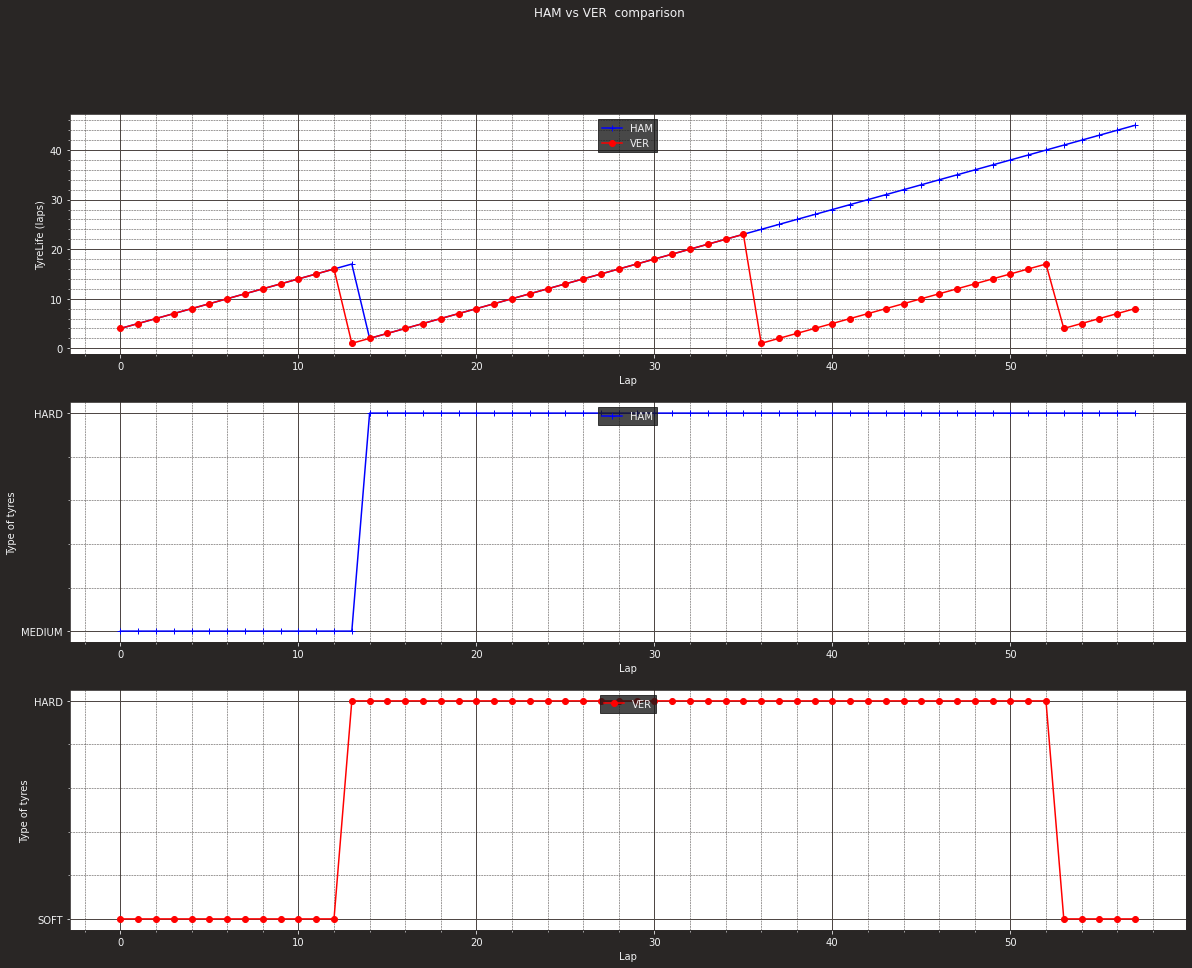

In [34]:
#plotting the second set
plt.rcParams['figure.figsize'] = [20, 15]

fig, ax = plt.subplots(3)
fig.suptitle("HAM vs VER  comparison")

ax[0].set_facecolor("white")
ax[1].set_facecolor("white")
ax[2].set_facecolor("white")

ax[0].plot(laps_ham['RaceLapNumber'], laps_ham['TyreLife'], label='HAM', marker = '+',  c = 'blue')
ax[0].plot(laps_ver['RaceLapNumber'], laps_ver['TyreLife'], label='VER', marker = 'o', c = 'red')
ax[0].set(ylabel='TyreLife (laps)', xlabel='Lap')
ax[0].legend(loc="upper center")        

ax[1].plot(laps_ham['RaceLapNumber'], laps_ham['Compound'], label='HAM', marker = '+',  c = 'blue')
ax[1].set(ylabel='Type of tyres', xlabel='Lap')
ax[1].legend(loc="upper center")

ax[2].plot(laps_ver['RaceLapNumber'], laps_ver['Compound'], label='VER', marker = 'o', c = 'red')
ax[2].set(ylabel='Type of tyres', xlabel='Lap')
ax[2].legend(loc="upper center")



plt.show()